# Segmentation


Requirements :
 - pytorch
 - wget, numpy, tqdm, scikit-image
 - 

In [3]:
import sys
!{sys.executable} -m pip install wget numpy tqdm

## Image segmentation

### Get the model

To perform image segmentation we will use the semantic-segmentation-pytorch project available here: https://github.com/CSAILVision/semantic-segmentation-pytorch.git.

In [4]:
! git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 758 (delta 0), reused 3 (delta 0), pack-reused 755
Receiving objects: 100% (758/758), 3.66 MiB | 7.72 MiB/s, done.
Resolving deltas: 100% (441/441), done.


In [5]:
! mv semantic-segmentation-pytorch semsegpt

mv: cannot move 'semantic-segmentation-pytorch' to 'semsegpt/semantic-segmentation-pytorch': Directory not empty


## Utils functions

In [6]:
import os
import matplotlib.image as mpimg

def create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
        
def create_all_paths(name_experiment):
    # paths from images
    images_path = name_experiment + '/images'
    # path for models
    models_path = 'models'
    model = 'baseline-resnet50dilated-ppm_deepsup'
    model_path = models_path + "/" + model
    encoder = model + '/encoder_epoch_20.pth'
    encoder_path = models_path + "/" + encoder
    decoder = model + '/decoder_epoch_20.pth'
    decoder_path = models_path + "/" + decoder
    # path for saving results
    results_path = name_experiment + '/segmentation_results'
    masks_path = name_experiment + '/masks'

    # creating dirs
    to_create = [name_experiment, images_path, models_path, model_path, results_path, masks_path]
    for folder in to_create:
        create_path(folder)
    if not os.path.exists(encoder_path):
        url = "http://sceneparsing.csail.mit.edu/model/pytorch/"+encoder
        wget.download(url,out=model_path)
    if not os.path.exists(decoder_path):
        url = "http://sceneparsing.csail.mit.edu/model/pytorch/"+decoder
        wget.download(url,out=model_path)
        
    return model_path, images_path, results_path, masks_path
  
def get_path_images(names,path):
    path_images = []
    for name in names:
        path_images += [path + "/" + name]
    return path_images
        
# downloads the images if it is not the case and return a CLI compatible string value of the list
def string_images(img_names,images_path,prefix=""):
    path_images = get_path_images(img_names,images_path)
    string_paths = ""
    for i in range(len(path_images)-1):
        string_paths += (prefix + path_images[i] + " ")
    string_paths += prefix + path_images[-1]
    return string_paths
  
def save_segmentation(image_path,save_dir):
    print(image_path,save_dir)
    img=mpimg.imread(image_path)
    width = img.shape[1]
    new = img[:,int(width/2):]
    save_path = save_dir + "/" + image_path.split("/")[-1]
    mpimg.imsave(save_path,new)

In [7]:
import wget
def generate_segmentation(name_experiment,images):
    base_dir = "experiments"
    create_path("experiments")
        
    os.chdir(base_dir)
    
    model_path, images_path, results_path, masks_path = create_all_paths(name_experiment)
    
    os.chdir("..")
        
    to_experiments = "../experiments/"
    string_paths = string_images(images,images_path,prefix=to_experiments)

    # generation of the cli
    cli = "test.py \
          --model_path " + to_experiments + model_path + " \
          --test_imgs " + string_paths + " \
          --arch_encoder resnet50dilated \
          --arch_decoder ppm_deepsup \
          --fc_dim 2048 \
          --result " + to_experiments + results_path
   
    ! cd semsegpt ; python $cli
    
    for image in images:
        res_path = "experiments/" + results_path + "/" + image[:-4] + '.png'
        save_segmentation(res_path,"experiments/" + masks_path)
      
    return "experiments/" + masks_path, results_path

In [8]:
import matplotlib.pyplot as plt
  
def plot_segmented_images(images):
    plt.figure(figsize=(20,10))
    columns = 2
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        img=mpimg.imread("experiments/" + results_path + "/" + image[:-4]+".png")
        # separate the image into input value and segmented value
        plt.imshow(img)

## Segmentation zones content

In [9]:
import scipy.io
import numpy as np
def rgb_to_hexa(color):
  # transforms to hexadecimal
  return '%02x%02x%02x' % (int(color[0]), int(color[1]), int(color[2]))
mat = scipy.io.loadmat('semsegpt/data/color150.mat')
RGBcolors = np.array(mat['colors'])
HEXcolors = [rgb_to_hexa(i) for i in RGBcolors]

In [10]:
def get_id_from_color(HEXcolor):
    for i in range(len(HEXcolors)):
        if HEXcolors[i]==HEXcolor:
            return i
    return -1

class Counter:
    def __init__(self):
        self.dict = {}
    def add(self,e):
        if e in self.dict:
            self.dict[e] += 1
        else:
            self.dict[e] = 1
    def top(self,k):
        i = 0
        r = []
        s = [k for k in sorted(self.dict, key=self.dict.get,reverse=True)]
        for key in s:
            r += [key]
            i += 1
            if i > k:
                break
        return r

import pandas
df = pandas.read_csv('semsegpt/data/object150_info.csv')
objects = list(df.Name)
def get_all_topics(segmented_image,k=3):
    m = len(segmented_image)
    n = len(segmented_image[0])
    c = Counter()
    for i in range(m):
        for j in range(n):
            hex = rgb_to_hexa(segmented_image[i][j]*255)
            c.add(hex)
    topics = ""
    for e in c.top(k):
        id = get_id_from_color(e)
        topics += objects[id] + ";"
    return topics
    

## Payasage transformation

In [11]:
name_experiment = "paysage"
os.chdir("experiments")
create_all_paths(name_experiment)
os.chdir("..")

! wget -O experiments/paysage/images/paysage1.jpg 'https://lemag.nikonclub.fr/wp-content/uploads/2017/07/08.jpg'
! wget -O experiments/paysage/images/paysage2.jpg 'https://www.superprof.fr/blog/file/2017/12/choisir-paysage-photo.jpg'
! wget -O experiments/paysage/images/paysage3.jpg 'https://www.geo.fr/var/geo/storage/images/voyages/vos-voyages-de-reve/namibie-a-travers-le-desert-grandiose-du-namib/route-de-cape-town-a-windhoek/1078719-1-fre-FR/route-de-cape-town-a-windhoek.jpg'
! wget -O experiments/paysage/images/paysage_nuit1.jpg 'http://blog.grainedephotographe.com/wp-content/uploads/2015/02/Divided-–-2014-Meri-Pori-Finland.jpeg'
! wget -O experiments/paysage/images/paysage_nuit2.jpg 'https://image.freepik.com/photos-gratuite/route-paysage-nuit-fond-galaxie-montagne-voie-lactee_34263-245.jpg'
! wget -O experiments/paysage/images/paysage_nuit3.jpg 'http://4everstatic.com/images/dessins/digital-art/paysage-de-nuit,-lac,-reflexion,-lune,-ciel-etoile-197184.jpg'

--2019-03-12 21:00:15--  https://lemag.nikonclub.fr/wp-content/uploads/2017/07/08.jpg
Resolving lemag.nikonclub.fr (lemag.nikonclub.fr)... 78.109.87.118
Connecting to lemag.nikonclub.fr (lemag.nikonclub.fr)|78.109.87.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588416 (2.5M) [image/jpeg]
Saving to: ‘experiments/paysage/images/paysage1.jpg’

experiments/paysage 100%[===================>]   2.47M  --.-KB/s    in 0.1s    

2019-03-12 21:00:15 (21.8 MB/s) - ‘experiments/paysage/images/paysage1.jpg’ saved [2588416/2588416]

--2019-03-12 21:00:15--  https://www.superprof.fr/blog/file/2017/12/choisir-paysage-photo.jpg
Resolving www.superprof.fr (www.superprof.fr)... 46.105.56.111
Connecting to www.superprof.fr (www.superprof.fr)|46.105.56.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78967 (77K) [image/jpeg]
Saving to: ‘experiments/paysage/images/paysage2.jpg’

experiments/paysage 100%[===================>]  77.12K  --.-KB/s   

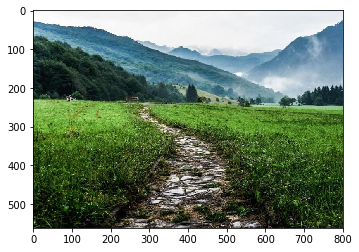

In [12]:
img=mpimg.imread("experiments/paysage/images/paysage2.jpg")
plt.imshow(img)

In [13]:
images = ['paysage1.jpg','paysage2.jpg','paysage_nuit1.jpg','paysage_nuit2.jpg']
masks, results_path = generate_segmentation("paysage",images)

Input arguments:
test_imgs        ['../experiments/paysage/images/paysage1.jpg', '../experiments/paysage/images/paysage2.jpg', '../experiments/paysage/images/paysage_nuit1.jpg', '../experiments/paysage/images/paysage_nuit2.jpg']
model_path       ../experiments/models/baseline-resnet50dilated-ppm_deepsup
suffix           _epoch_20.pth
arch_encoder     resnet50dilated
arch_decoder     ppm_deepsup
fc_dim           2048
num_val          -1
num_class        150
batch_size       1
imgSize          [300, 400, 500, 600]
imgMaxSize       1000
padding_constant 8
segm_downsampling_rate 8
result           ../experiments/paysage/segmentation_results
gpu              0
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 4
100%|█████████████████████████████████████████████| 4/4 [00:25<00:00,  6.84s/it]Inference done!

experiments/paysage/segmentation_results/paysage1.png experiments/paysage/masks
experiments/paysage/segmentation_results/paysage2.png experiments/paysage/masks
ex

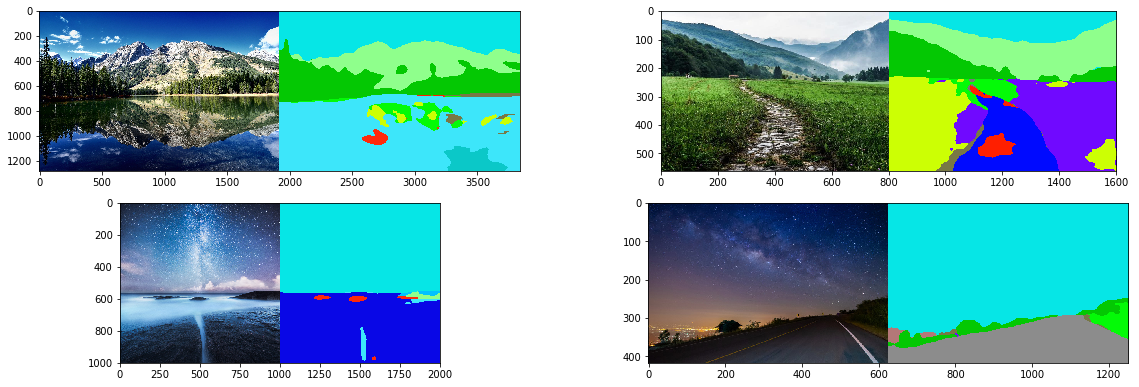

In [14]:
plot_segmented_images(images)

## Time to do some style transfer !

In [15]:
! git clone https://github.com/yagudin/PyTorch-deep-photo-styletransfer.git
! mv PyTorch-deep-photo-styletransfer styletransfer

Cloning into 'PyTorch-deep-photo-styletransfer'...
remote: Enumerating objects: 430, done.
remote: Total 430 (delta 0), reused 0 (delta 0), pack-reused 430
Receiving objects: 100% (430/430), 164.43 MiB | 37.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [16]:
import sys
!{sys.executable} -m pip install scikit-image

In [17]:
import torch
import torchvision.models as models

from toolbox.image_preprocessing import image_loader, masks_loader, plt_images
os.chdir("styletransfer")
from neural_style import run_style_transfer
os.chdir("..")

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)

In [19]:
idx = 1
idy = 1

style_img = image_loader('experiments/paysage/images/paysage{}.jpg'.format(idx), imsize).to(device, torch.float)
content_img = image_loader('experiments/paysage/images/paysage_nuit{}.jpg'.format(idy), imsize).to(device, torch.float)
input_img = content_img.clone()
  
style_masks, content_masks = masks_loader(
    masks + '/paysage{}.png'.format(idx),
    masks + '/paysage_nuit{}.png'.format(idy),
    imsize)

/home/nicolaszucchet/miniconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


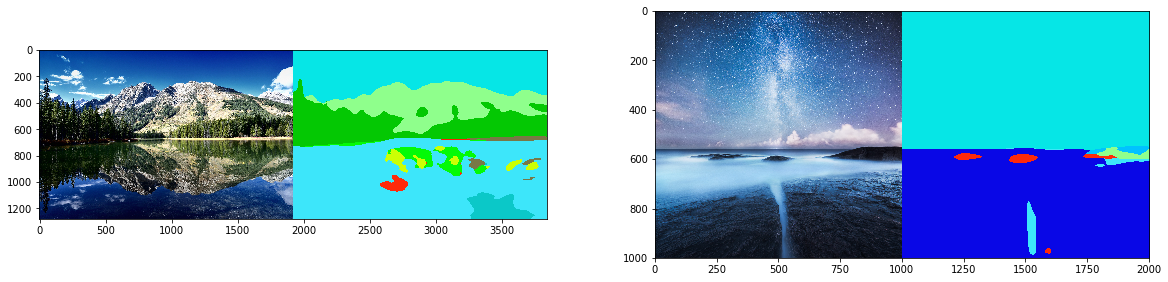

In [20]:
plot_segmented_images(["paysage{}.png".format(idx),"paysage_nuit{}.png".format(idy)])

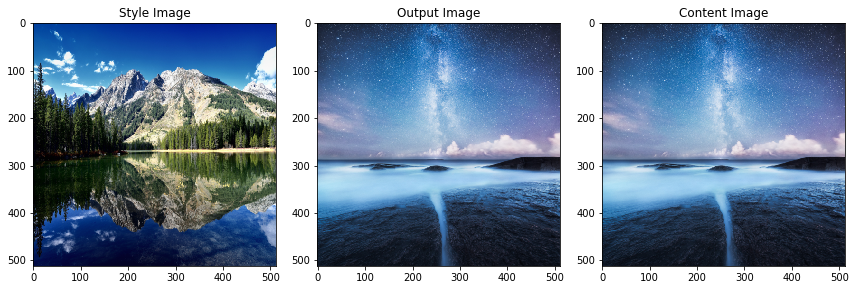

In [21]:
plt_images(style_img.cpu(), input_img.cpu(), content_img.cpu())

In [22]:
get_all_topics(mpimg.imread("experiments/paysage/masks/paysage_nuit1.png"),k=10)

'sky;sea;water;rock;stone;mountain;mount;land;ground;soil;'

In [23]:
# pipelines bootstrapping
from PIL import Image
img = Image.open("experiments/paysage/images/paysage1.jpg")
img.save("examples/input/in3.png", "PNG")
img = Image.open("experiments/paysage/images/paysage_nuit1.jpg")
img.save("examples/style/tar3.png", "PNG")
!cp experiments/paysage/masks/paysage1.png examples/segmentation
!mv examples/segmentation/paysage1.png examples/segmentation/in3.png
!cp experiments/paysage/masks/paysage_nuit1.png examples/segmentation
!mv examples/segmentation/paysage_nuit1.png examples/segmentation/tar3.png

### Define experience paramaters

In [62]:
name = "3"
num_epochs = 500

quick = False
ghost  = False
quiet = False

content_index = 3
style_index = 3
imsize = 128#512 if torch.cuda.is_available() else 128

style_weight = 1e6
content_weight = 1e1
reg_weight = 1e-8

content_layers = ['4_2']
style_layers = ['1_1','2_1','3_1','4_1']

optimizer = "lbfgs"
learning_rate = 1
momentum = 0.9
weight_decay = 1e-3

scheduler = "step"
lr_step = 100
lr_decay = 5e-1

query = "main.py -name {} -num_epochs {} -style_image {} -content_image {} -imsize {} -style_weight {} -content_weight {} -reg_weight {} -content_layers {} -style_layers {} -optimizer {} -lr {} -momentum {} -weight_decay {} -scheduler {} -lr_step {} -lr_decay {}".format(
    name,
    num_epochs,
    content_index,
    style_index,
    imsize,
    style_weight,
    content_weight,
    reg_weight,
    " ".join(content_layers),
    " ".join(style_layers),
    optimizer,
    learning_rate,
    momentum,
    weight_decay,
    scheduler,
    lr_step,
    lr_decay
  )

if quick:
    query += " -quick"
if ghost:
    query += " -ghost"
if quiet:
    query += " -quiet"

You have entered an experiment name that already exists even though you are not resuming that experiment, do you wish to continue (this will delete the folder: experiments/3/). [y/n] y
----- Experiments Parameters -----
name : 3
quick : False
ghost : False
no_metrics : False
style_image : 3
content_image : 3
imsize : (128, 128)
keep_params : False
base_model : vgg19
device : cuda
content_layers : ['conv4_2']
style_layers : ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
num_epochs : 500
style_weight : 1000000.0
content_weight : 10.0
reg_weight : 1e-08
optimizer : lbfgs
lr : 1.0
momentum : 0.9
weight_decay : 0.001
scheduler : step
lr_step : 100
lr_decay : 0.5
seed : 42
no_log : False
reg : True
save_model : True
resume_model : False
load_name : 
verbose : True
work_dir : 
save_name : 3
res_dir : experiments/3/
load_path : experiments//save/
load_model_path : experiments//save/model.pt
load_parameters_path : experiments//save/parameters.json
load_experiment_path : experiments//save/experime

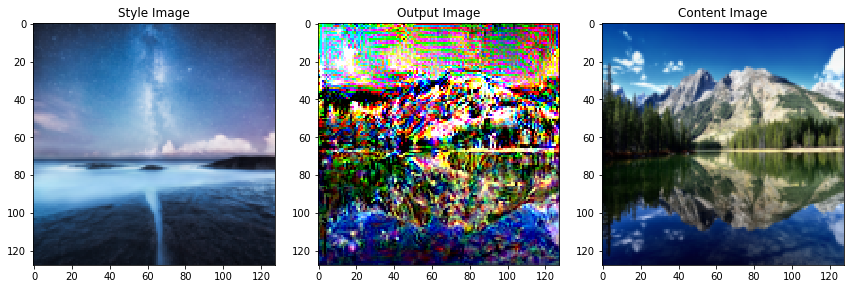

In [63]:
from main import *

%matplotlib inline

experience = create_experience(query)

parameters = experience["parameters"]
experiment = experience["experiment"]
listener = experience["listener"]
log = experience["log"]
optimizer = experience["optimizer"]
losses = experience["losses"]
model = experience["model"] 
scheduler = experience["scheduler"]

run_experience(experiment, model, parameters, losses, optimizer, scheduler, listener, log)

print()

experiment.input_image.data.clamp_(0, 1)

log.info("Done style transfering over "+str(experiment.epoch)+" epochs!")

if parameters.save_model:
    save_all(experiment,model,parameters,listener)
if not(parameters.ghost):
    save_images(parameters.res_dir+"output.png",experiment.style_image,experiment.input_image,experiment.content_image)

print("All done")

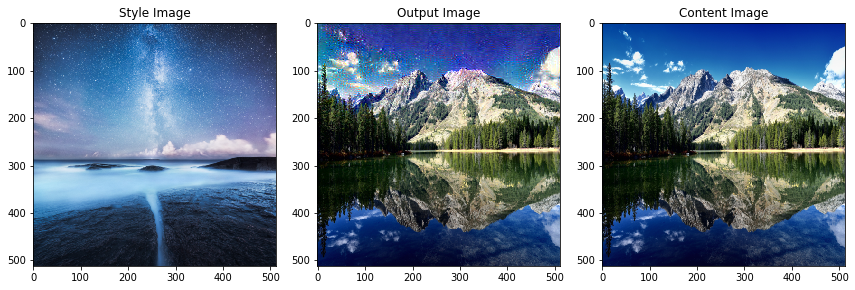

In [60]:
plt_images(experiment.style_image,experiment.input_image,experiment.content_image)

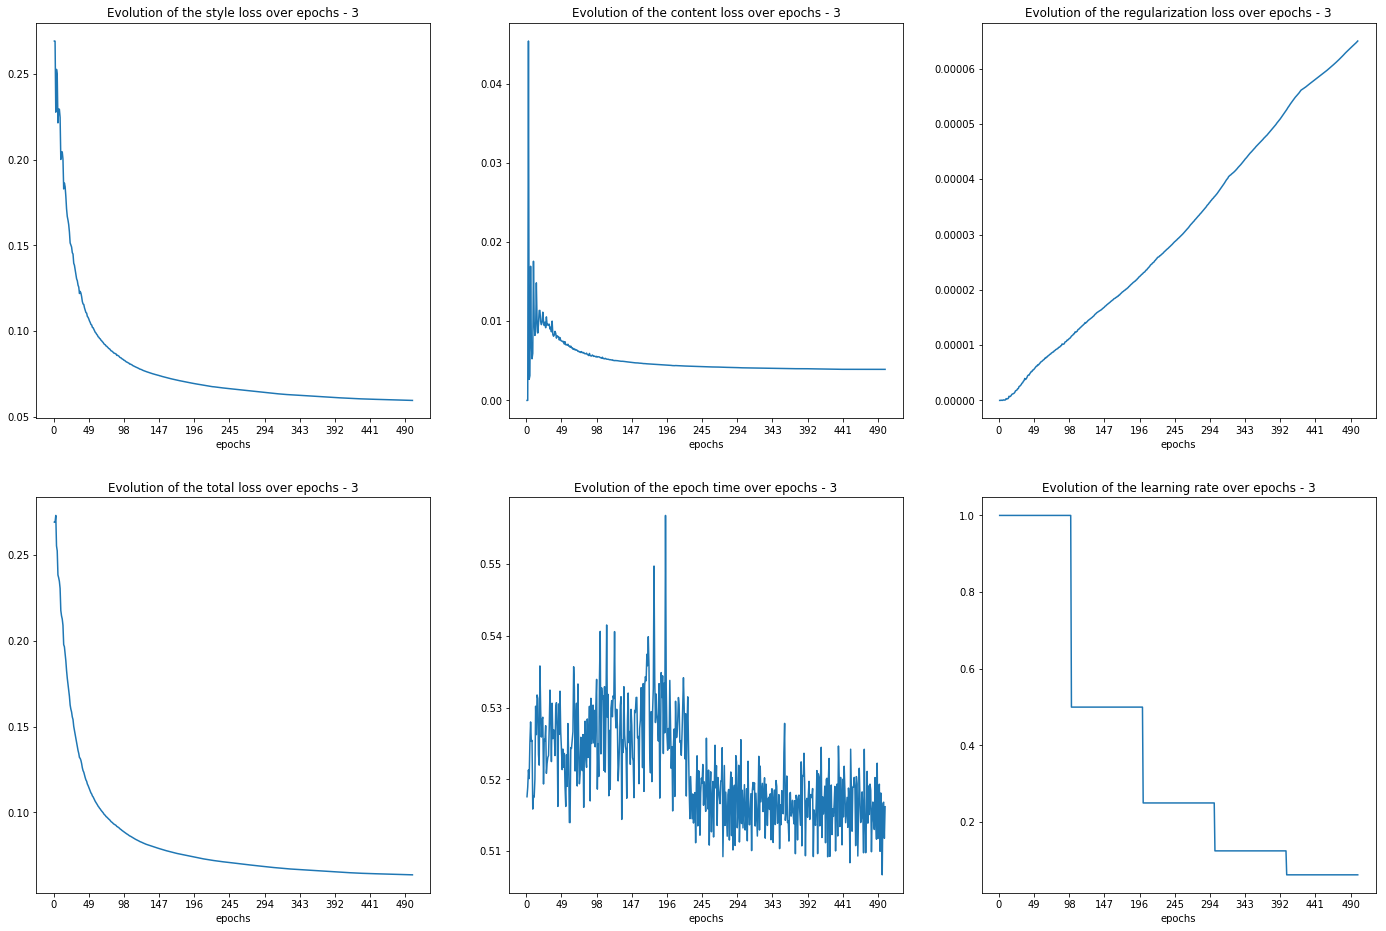

In [61]:
if not(parameters.no_metrics):
    generate_plots(parameters, listener)